# When is a network a network? Multi-Order Model Selection in Pathways and Temporal Networks

### An educational tutorial introducing the OpenSource `python` package [`pathpy`](https://github.com/IngoScholtes/pathpy)

Ingo Scholtes  
[Chair of Systems Design](http://www.sg.ethz.ch)  
ETH Zürich  

*February 23 2017*

## Summary

This educational tutorial introduces the **analysis of sequential data using multi-order graphical models**, based on the python package [`pathpy`](https://github.com/IngoScholtes/pathpy).

<a name="references"></a>

The theoretical foundation of this package has been outlined in the recent paper:  

- I Scholtes: [When is a network a network? Multi-Order Graphical Model Selection in Pathways and Temporal Networks](https://arxiv.org/abs/1702.05499), arXiv:1702.05499, February 2017

Moreover, it builds on **higher-order network abstractions** of time-stamped data, as well as **high-order centrality measures** developed in: 

- I Scholtes, N Wider, A Garas: [Higher-Order Aggregate Networks in the Analysis of Temporal Networks: Path structures and centralities](http://link.springer.com/article/10.1140%2Fepjb%2Fe2016-60663-0), The European Physical Journal B, 89:61, March 2016  
- I Scholtes, N Wider, R Pfitzner, A Garas, CJ Tessone, F Schweitzer: [Causality-driven slow-down and speed-up of diffusion in non-Markovian temporal networks](http://dx.doi.org/10.1140/epjb/e2016-60663-0), Nature Communications, 5, September 2014  
- R Pfitzner, I Scholtes, A Garas, CJ Tessone, F Schweitzer: [Betweenness preference: Quantifying correlations in the topological dynamics of temporal networks](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.110.198701), Phys Rev Lett, 110(19), 198701, May 2013  

A key feature of `pathpy` is that it provides a unified approach to the analysis of pathways and temporal networks. Let us first define what we mean by pathway data. We consider sequential data of the form ... 

$(a \rightarrow b)$  
$(b \rightarrow c)$  
$(a \rightarrow b \rightarrow c)$  
$(b \rightarrow c \rightarrow a)$  
$(a \rightarrow b \rightarrow c \rightarrow d)$  
$(c)$  

... which capture multiple (typically short) paths with varying lengths, observed in a network topology. Such data are relevant in a number of data mining scenarios: Consider, for instance, click streams of multiple users in the Web. Each line above could be the navigation path of a user in a Web graph. Considering biological pathways, each line could be one activation sequence of genes observed in a cell. In social media, paths could be traces of information propagating through a social network. Finally, we will show that pathway data also naturally emerge in time-stamped interaction data, which makes `pathpy` **particularly useful for those studying temporal networks**.

In this tutorial we show that such sequential data allow us to provide a principled answer to the crucial question: **Is it justified to model a system as a network**, i.e. can we apply graph-theoretic or network-analytic methods to a relational data set?  

Apart from answering this important question, `pathpy` allows to infer **optimal higher-order graphical models** which generalize the commonly used network abstraction and facilitate the analysis of sequential data. 

The outline of this tutorial is as follows:

<a name="outline"></a>
1. [Setting up pathpy](#setup)
2. [Getting started: the Paths object](#paths)
3. [Analyzing temporal networks: the TemporalNetwork class](#temporal)
4. [Importing data on pathways and temporal networks](#data)
5. [Multi-Order graphical models of pathways and temporal networks](#multiorder)
6. [When is a network a network?](#network)
7. [Conclusion](#conclusion)

<a name="setup"></a>
## 1. Setting up `pathpy`
*[Back to outline](#outline)*

Before diving into the theoretical foundation of our framework, let us first install and setup `pathpy`. The package consist of pure `python` code which means that there are no platform-specific dependencies that complicate the setup. The only requirement is that you have a `python` interpreter (version 3 and above) as well as the packages `numpy` and `scipy`, which are used for mathematical calculations.  

The code of `pathpy` is available at [gitHub](https://github.com/IngoScholtes/pathpy). Downloading and installing the latest version of `pathpy` is simple. Just fire up a console and type: 

`> pip install git+git://github.com/IngoScholtes/pathpy.git`

This will download and install the latest development version of `pathpy` and its dependencies. If you want to install a specific [release version](https://github.com/IngoScholtes/pathpy/releases), you can type: 

`> pip install https://github.com/IngoScholtes/pathpy/archive/VERSIONTAG.zip`  

where `VERSIONTAG` is the tag of the release. In this tutorial, we use the first beta release `v1.0-beta.1`, so we run 

`> pip install https://github.com/IngoScholtes/pathpy/archive/v1.0-beta.1.zip`

While `pathpy` does not depend on any specific graph library, for illustration purposes this tutorial will use network visualizations generated by `python-igraph`. We can set this up by running:

`> pip install python-igraph`

However, `igraph` is not needed to use `pathpy` unless you wan to visualize higher-order graphical models. Now that everything is installed, we can import `pathpy`, `numpy` and `igraph` in our script. We will also use the `IPython.display` function to plot some figures later, so let us import that as well.

In [1]:
import igraph
import numpy as np
import pathpy as pp

from IPython.display import *
from IPython.display import HTML

<a name="paths"></a>
## 2. Getting started: the `Paths` object
*[Back to outline](#outline)*

One of the key objects in `pathpy` is the `Paths` class. It can be used to import, manipulate and analyze pathways like in the example above. As we will see later, we can also use it to generate pathways from temporal networks. For now, let us create an empty `Paths` instance as follows:

In [2]:
paths = pp.Paths()

We can manually add paths to this object using the function `addPath`. Since all classes and functions in `pathpy` are documented using so-called `python docstrings` we can use `python`'s interactive help system to print the documentation of this function.

In [3]:
help(paths.addPath)

Help on method addPath in module pathpy.Paths:

addPath(ngram, separator=',', expandSubPaths=True, pathFrequency=None) method of pathpy.Paths.Paths instance
    Adds the path(s) of a single n-gram to the path statistics object.
    
    @param ngram: An ngram representing a path between nodes, separated by the separator character, e.g. 
        the 4-gram a;b;c;d represents a path of length three (with separator ';')
    
    @param separator: The character used as separator for the ngrams (';' by default)
    
    @param expandSubPaths: by default all subpaths of the given ngram are generated, i.e. 
        for the trigram a;b;c a path a->b->c of length two will be generated 
        as well as two subpaths a->b and b->c of length one
    
    @weight weight: the weight (i.e. frequency) of the ngram



The function takes a string argument, as well as a separator character. The string is an *n-gram* which consists of $n$ symbols separated by the separator character (default: ","). Each symbol in this n-gram represents a node or vertex traversed by a path of length $n-1$ (we define the length of a path as the number of links it traverses). So the pathways from the example above can be generated as follows:

In [4]:
paths.addPath('a,b')
paths.addPath('b,c')
paths.addPath('a,b,c')
paths.addPath('b,c,a')
paths.addPath('a,b,c,d')
paths.addPath('c')

We can print the `Paths` instance to get a human-readable summary:

In [5]:
print(paths)

Number of paths (unique/sub paths/total):	6 (6/23/29)
Nodes:				4
Edges:				4
Max. path length:		3
Avg path length:		1.5
Paths of length k = 0		1 (1/14/15)
Paths of length k = 1		2 (2/7/9)
Paths of length k = 2		2 (2/2/4)
Paths of length k = 3		1 (1/0/1)



This instance contains six paths: One path consists of a single node and has length zero (remember the path length is the number of traverse links). Two paths have length one and two respectively, and a single path has length three. The network in which these paths occur has four nodes $a$, $b$, $c$, and $d$ connected by four directed links/edges $(a,b)$, $(b,c)$, $(c,a)$, and $(c,d)$. 

You will notice a group of three numbers after each path length. The first number counts unique ocurrences of paths. This becomes clear if we add a second occurrence of path $(a \rightarrow b)$:

In [6]:
paths.addPath('a,b')
print(paths)

Number of paths (unique/sub paths/total):	7 (6/25/32)
Nodes:				4
Edges:				4
Max. path length:		3
Avg path length:		1.42857142857
Paths of length k = 0		1 (1/16/17)
Paths of length k = 1		3 (2/7/10)
Paths of length k = 2		2 (2/2/4)
Paths of length k = 3		1 (1/0/1)



We now have a total of seven observations of six unique paths (one path occuring twice). Rather than adding multiple observations by hand, we can actually set frequencies (or weights) of paths. So, rather than adding $(a \rightarrow b)$ twice we could have written the following to get the same result:

In [7]:
paths = pp.Paths()
paths.addPath('a,b', pathFrequency=2)
paths.addPath('b,c')
paths.addPath('a,b,c')
paths.addPath('b,c,a')
paths.addPath('a,b,c,d')
paths.addPath('c')
print(paths)

Number of paths (unique/sub paths/total):	7 (6/25/32)
Nodes:				4
Edges:				4
Max. path length:		3
Avg path length:		1.42857142857
Paths of length k = 0		1 (1/16/17)
Paths of length k = 1		3 (2/7/10)
Paths of length k = 2		2 (2/2/4)
Paths of length k = 3		1 (1/0/1)



What about the second number in the group of three numbers? It counts the number of so-called sub-paths. For a path $p=(a \rightarrow b \rightarrow c \rightarrow d)$ we call any sequence of nodes $q$ which is contained in $p$ a sub-path of $p$. I.e. $q_1=(a \rightarrow b)$, $q_2=(b \rightarrow c \rightarrow d)$ or the single node $q_3=(b)$ are sub-paths of path $p$.

Correctly accounting for sub-paths of any length is crucial for our graphical modeling framework. Whenever we add a path (using the default parameter `expandSubPaths=True`) all sub-paths of the added path will be automatically calculated. In the example above, this means that there are a total of $16$ sub-paths of length zero (single nodes). Note that $(a\rightarrow b)$ is occurring twice and $(c)$ is an actual path with length zero for which no additional sub-path is counted. Similarly, there are seven sub-paths of length one, etc.

We can access paths via a public dictionary `paths`, which contains the list (and frequencies) of paths of any length. For the example above, we can, e.g., access paths of length two as follows:

In [8]:
paths.paths[2]

defaultdict(<function pathpy.Paths.Paths.__init__.<locals>.<lambda>.<locals>.<lambda>>,
            {('a', 'b', 'c'): array([1, 1]),
             ('b', 'c', 'a'): array([0, 1]),
             ('b', 'c', 'd'): array([1, 0])})

This returns a dictionary which contains three different paths of length two, each of which is associated with a tuple consisting of two numbers. The first counts the **actual path observations**, the second number counts the **occurrences of a path as a sub-path** of a longer path observation. In the example above, path $(a \rightarrow b \rightarrow c)$ has been observed one time as an actual path, and one time as a sub-path of the longer path $(a\rightarrow b \rightarrow c \rightarrow d)$. The path $(b \rightarrow c \rightarrow a)$ never occurs as sub-path, while $(b \rightarrow c \rightarrow d)$ only occurs as a sub path of $(a \rightarrow b \rightarrow c \rightarrow d)$.

<a name="temporal"></a>
## 3. Analyzing temporal networks: the `TemporalNetwork` class
*[Back to outline](#outline)*

A key design principle behind `pathpy` is that it unifies the analysis of pathway data (introduced above) and **time-stamped data on temporal networks**. We consider a temporal network as a collection of triplets of the form $(a,b;t)$ which capture that a node $a$ was connected to node $b$ (via a directed link) at a discrete time $t$. Such time-stamped data are of increasing importance, for instance when studying time-stamped interactions in a social network.  

We can represent such time-stamped network data using `pathpy`'s `TemporalNetwork` class. Let us create an empty instance:

In [9]:
t = pp.TemporalNetwork()

We can add time-stamped edges to this temporal network in any order:

In [10]:
t.addEdge(source='a', target='b', ts=42)
t.addEdge(source='b', target='c', ts=21)
t.addEdge(source='c', target='d', ts=51)
t.addEdge(source='b', target='c', ts=44)

Again, printing the instance will return a human-readable summary:

In [11]:
print(t)

Nodes:			4
Time-stamped links:	4
Links/Nodes:		1.0
Observation period:	[21, 51]
Observation length:	30
Time stamps:		4
Avg. inter-event dt:	10.0
Min/Max inter-event dt:	2/21



This temporal network consists of four nodes connected by four time-stamped links. The observation period covers 30 time units and contains four different time stamps with observed edges. The average inter-event time between "events" is 10 time units, the minimum and the maximum difference between any two consecutive events are two and 21 time units respectively.

Now you may ask: How are temporal networks related to the pathways above and how can we study both from the same perspective?

Well, the point is that temporal networks naturally give rise to **time-respecting paths**, i.e. paths consisting of sequences of time-stamped links which (minimally) satisfy **causality**. Specifically, two time-stamped links $(a,b;t_1)$ and $(b,c;t_2)$ contribute to a time-respecting path $a \rightarrow b \rightarrow c$ if $t_1<t_2$, i.e. if the link $(a,b)$ occurs **before** $(b,c)$. Apart from the condition that links have to occur in the correct order, it is common to impose a **maximum time difference** between consecutive links. I.e. we define a maximum time difference $\delta$ and consider two time-stamped edges $(a,b;t)$ and $(b,c;t')$ to contribute to a time-respecting path if $0 \leq t'-t \leq \delta$. Imposing this additional condition is natural, since we are typically interested in paths which occur at short time scales. Especially, when considering time-stamped data collected over a period of several days, weeks or even years, it is usually not reasonable to consider a path definition where links can be weeks or years apart.

With this definition of time-respecting paths at hand, we can extract pathways from a sequence of time-stamped edges based on a given value of $\delta$. We can directly do this in `pathpy` using a built-in method to extract time-respecting paths for arbitrary $\delta$. Let us try this for $\delta=\inf$, i.e. we don't impose a constraint for the maximum time difference, but still require that links occur in the right order:

In [12]:
trp = pp.Paths.fromTemporalNetwork(t, delta=np.inf)
print(trp)

2017-03-01 17:16:53 [Severity.INFO]	Extracting time-respecting paths for delta = inf ...
2017-03-01 17:16:53 [Severity.INFO]	Calculating sub path statistics ... 
2017-03-01 17:16:53 [Severity.INFO]	finished.
Number of paths (unique/sub paths/total):	3 (2/19/22)
Nodes:				4
Edges:				3
Max. path length:		3
Avg path length:		2.33333333333
Paths of length k = 0		0 (0/10/10)
Paths of length k = 1		0 (0/7/7)
Paths of length k = 2		2 (1/2/4)
Paths of length k = 3		1 (1/0/1)



Here we have two time-respecting paths $(b,c;21) \rightarrow (c,d;51)$ and $(b,c;44) \rightarrow (c,d;51)$ of length two and a path $(a,b;41) \rightarrow (b,c;44) \rightarrow (c,d;51)$ of length three. In addition, all shorter time-respecting paths which are sub paths of the three detected paths are automatically accounted for in the sub-path counts given in the second number in the brackets. If we instead set $\delta$ to a smaller value like $\delta=5$, we get different (time-respecting) paths:

In [13]:
trp = pp.Paths.fromTemporalNetwork(t, delta=5)
print(trp)

2017-03-01 17:16:53 [Severity.INFO]	Extracting time-respecting paths for delta = 5 ...
2017-03-01 17:16:53 [Severity.INFO]	Calculating sub path statistics ... 
2017-03-01 17:16:53 [Severity.INFO]	finished.
Number of paths (unique/sub paths/total):	3 (3/9/12)
Nodes:				4
Edges:				3
Max. path length:		2
Avg path length:		1.33333333333
Paths of length k = 0		0 (0/7/7)
Paths of length k = 1		2 (2/2/4)
Paths of length k = 2		1 (1/0/1)



Now we only have two paths of length one (which are just time-stamped edges without a continuation towards a longer time-respecting path) and a single path $(a,b;42) \rightarrow (b,c;44)$ of length two for which the time difference between edges is less than five.

In summary, `pathpy` makes it very easy to extract (time-respecting) paths from time-stamped data on temporal networks. Thanks to this, **both pathway and temporal network data can be studied from the same perspective**.

<a name="data"></a>
## 4. Importing data on pathways and temporal networks
*[Back to outline](#outline)*

Rather than manually adding paths or time-stamped edges, we can directly read `Paths` and `TemporalNetwork` instances from data files.

For pathway data, the `Paths` class can be used to read **n-gram files**, i.e. text files where each line contains a path with variable length. Vertices can be arbitrary strings, separated by a special character that can be set when reading the file. `pathpy` supports data where each path is observed multiple times. This either works by reading files where identical paths occur in multiple lines of the file, or by including a special last column in each line which contains the number of observations of a path.

Such an n-gram file can look like the following excerpt from a file that captures [travel itineraries of passengers of the London Tube](https://tfl.gov.uk/info-for/open-data-users/), recorded via smartcard readers: 

`344,314,445,440,513,346,305,312,289,367,356,299,376,9`  
`339,303,323,376,299,356,367,289,312,305,346,400,465,382,325,7`  
`296,430,474,271,332,331,441,341,280,294,362,528,344,493,29`  
`...`  

Numbers indicate metro stations passed by on an itinerary, except for the last column which indicates the number of times the given path was observed. If we save such data in a textfile called `tube_paths.ngram`, we can read it as follows:

In [14]:
tube_paths = pp.Paths.readFile('pathpy_tutorial/tube_paths.ngram', separator=',', pathFrequency=True)
print(tube_paths)

2017-03-01 17:16:53 [Severity.INFO]	Reading ngram data ... 
2017-03-01 17:16:54 [Severity.INFO]	finished. Read 32918 paths with maximum length 35
2017-03-01 17:16:54 [Severity.INFO]	Calculating sub path statistics ... 
2017-03-01 17:17:15 [Severity.INFO]	finished.
Number of paths (unique/sub paths/total):	4295731 (32313/182041358/186337089)
Nodes:				276
Edges:				663
Max. path length:		35
Avg path length:		6.86497129359
Paths of length k = 0		0 (0/33785801/33785801)
Paths of length k = 1		186435 (594/29303635/29490070)
Paths of length k = 2		337975 (912/24856364/25194339)
Paths of length k = 3		446941 (1288/20638102/21085043)
Paths of length k = 4		453255 (1696/16860467/17313722)
Paths of length k = 5		467697 (2040/13521645/13989342)
Paths of length k = 6		438374 (2316/10679843/11118217)
Paths of length k = 7		369090 (2460/8345699/8714789)
Paths of length k = 8		317013 (2529/6432722/6749735)
Paths of length k = 9		277742 (2572/4876029/5153771)
Paths of length k = 10		229761 (2481/3645

The large numbers result from the calculation of sub-path statistics outlined above. Here, the fact that this data set contains many long paths results in more than 180 million shorter sub-paths which are contained within longer pathways.

We finally show how we can read temporal networks from data files. Here we assume that we are given a data file that has the following format 

`time source target`  
`28820 492 938`  
`28860 267 272`  
`29300 181 826`  
`...`  

Each line captures a directed time-stamped edge from source to target, happening instantaneously at the indicated time stamp. The header column tells which column is which. The ordering of columns can be arbitrary and the character that separates column can be specified. 

The above lines are actually an excerpt from a time-stamped data set released by the [SocioPatterns collaboration](http://www.sociopatterns.org). It captures [face-to-face encounters of workers in a company](http://www.sociopatterns.org/datasets/contacts-in-a-workplace/), recorded via sensor badges. We can read this data file to a `TemporalNetwork` instance as follows:

In [15]:
work_t = pp.TemporalNetwork.readFile('pathpy_tutorial/WorkplaceContacts.tedges', sep=' ')
print(work_t)

2017-03-01 17:17:16 [Severity.INFO]	Reading time-stamped links ...
2017-03-01 17:17:16 [Severity.INFO]	Building index data structures ...
2017-03-01 17:17:16 [Severity.INFO]	Sorting time stamps ...
2017-03-01 17:17:16 [Severity.INFO]	finished.
Nodes:			92
Time-stamped links:	9827
Links/Nodes:		106.81521739130434
Observation period:	[28820, 1016440]
Observation length:	987620
Time stamps:		7104
Avg. inter-event dt:	139.042658032
Min/Max inter-event dt:	20/222680



Now we can pick a maximum time difference $\delta$ and extract all time-respecting paths as explained above. Here we choose a maximum time difference of three minutes, which gives the following time-respecting path statistics:

In [16]:
work_paths = pp.Paths.fromTemporalNetwork(work_t, delta=180)
print(work_paths)

2017-03-01 17:17:16 [Severity.INFO]	Extracting time-respecting paths for delta = 180 ...
2017-03-01 17:17:17 [Severity.INFO]	Calculating sub path statistics ... 
2017-03-01 17:17:17 [Severity.INFO]	finished.
Number of paths (unique/sub paths/total):	10939 (968/31879/42818)
Nodes:				92
Edges:				755
Max. path length:		4
Avg path length:		1.28393820276
Paths of length k = 0		0 (0/24984/24984)
Paths of length k = 1		8467 (669/5578/14045)
Paths of length k = 2		1887 (252/1219/3106)
Paths of length k = 3		536 (41/98/634)
Paths of length k = 4		49 (6/0/49)



<a name="multiorder"></a>
## 5. Multi-Order Graphical Models of Pathways and Temporal Networks
*[Back to outline](#outline)*

Now that we can import data on pathways and temporal networks, we turn our attention to the multi-order graphical modeling framework which is the theoretical foundation of our data mining techniques. The mathematical details have been developed in [this recent article](https://arxiv.org/abs/1702.05499). Here we provide a short (and rather high-level) introduction.

Consider a toy network which consists of five nodes $a,b,c,d,e$ connected by four links $(a,c), (b,c), (c,d), (c,e)$. We further assume that we have a total of 18 observations of the following eight unique paths:

In [17]:
paths = pp.Paths()
paths.addPath('a,c', pathFrequency=2)
paths.addPath('b,c', pathFrequency=1)
paths.addPath('c,d', pathFrequency=3)
paths.addPath('c,e', pathFrequency=2)
paths.addPath('a,c,d', pathFrequency=5)
paths.addPath('b,c,e', pathFrequency=6)
print(paths)

Number of paths (unique/sub paths/total):	19 (6/71/90)
Nodes:				5
Edges:				4
Max. path length:		2
Avg path length:		1.57894736842
Paths of length k = 0		0 (0/49/49)
Paths of length k = 1		8 (4/22/30)
Paths of length k = 2		11 (2/0/11)



The question we are going to address is: Considering the statistics of observed paths, is it justified to model the underlying system as a network? And if not, what would be an optimal graphical abstraction for the data set?

We address these important questions based on ["higher-order" networks](https://www.sg.ethz.ch/team/people/ischoltes/research-insights/temporal-networks-demo/) introduced in [this Nature Communications article](http://www.nature.com/ncomms/2014/140924/ncomms6024/full/ncomms6024.html). Here, we generalize this approach to (i) multi-order models which combine multiple layers of higher-order networks, and (ii) pathway data.

So what is the problem if we model the system above as a graph or network? The problem is that graph- and network-analytic methods like centrality measures, community detection, etc. are implicitly based on the **assumption that paths in a network are transitive**, i.e. if we observe a path from node $u$ to node $v$ and a path from node $v$ to node $w$, we implicitly assume that there is a transitive path from $u$ via $v$ to $w$. This fundamental assumption is due to the way how graph algorithms (as well as algebraic methods which rely on matrix multiplication or spectral analysis) work. However, what is important to see is that **correlations in the sequence of nodes traversed by paths can invalidate the assumption of transitivity** (see [discussion here](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.110.198701)).

Consider the example above: Since the network has two edges $(a,c)$ and $(c,e)$ we would expect that a path of length two from $a$ via $c$ to $e$ exists. But this is actually not the case. Instead, whenever a path traverses from $a$ to $c$, it continues to $d$. Likewise, whenever a path traverses from $b$ to $c$, it continues to $e$. The transitive path $(b \rightarrow c \rightarrow d)$, which we expect based on the link topology of the graph, never occurs. 

So the question really is: Is the topology of the underlying graph enough to explain the statistics of observed paths? Note that the example above is an extreme example, where two transitive paths are completely absent. Rather than being completely absent, we could also have cases where paths are just less (or more) frequent than what we expect. Clearly, such an under- or overrepresentation of paths violates the transitivity assumption of a network abstraction as well (though possibly to a lesser degree).

While we refer to [the publications above](#references) for a detailed mathematical description of our approach, the key idea is to consider [Markov chain models of different orders](https://en.wikipedia.org/wiki/Markov_chain) which are tailored to reproduce the statistics of paths observed in a given graph topology. We specifically use a graphical construction that resembles [De Bruijn graphs](https://en.wikipedia.org/wiki/De_Bruijn_graph) known from sequence modeling.

This is how it works: We first consider a "first-order" network abstraction which simply counts the frequencies at which edges are traversed by paths. We can generate such a first-order abstractions of our observed paths using the `HigherOrderNetwork` class provided by `pathpy` as follows:

In [18]:
network = pp.HigherOrderNetwork(paths, k=1)

To visualize this network model, we provide the following helper function, which takes an instance of the `HigherOrderNetwork` class and returns an `igraph` `Graph` object that we can use to plot the network topology. The current version of `pathpy` specifically does not include plotting and visualization tools since (i) we want the package to have minimal dependencies, and (ii) the function below shows that it is very easy to construct `igraph` (and similarly [`graph-tool`](https://graph-tool.skewed.de/)) instances from a `HigherOrderNetwork` object.

In [19]:
def Network2igraph(network):
    """ 
    Returns an igraph Graph object which represents 
    the k-th layer of a multi-order graphical model.
    """
    g = igraph.Graph(directed=True)

    for e in network.edges:
        if g.vcount()== 0 or e[0] not in g.vs()["name"]:
            g.add_vertex(e[0])
        if g.vcount()== 0 or e[1] not in g.vs()["name"]:
            g.add_vertex(e[1])
        g.add_edge(e[0], e[1], weight=network.edges[e].sum())
    return g

We can now use `igraph`'s visual styling and plotting features to plot the network representation.

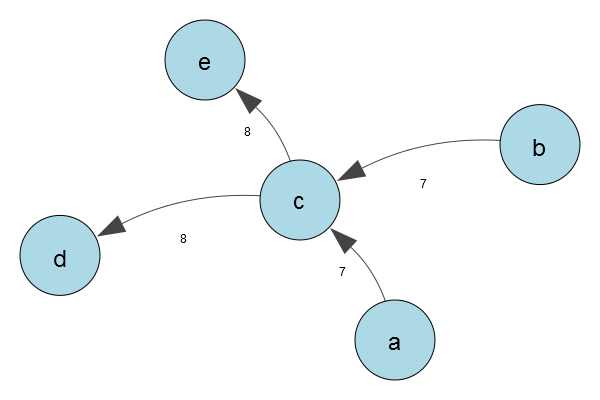

In [20]:
g1 = Network2igraph(network)
igraph.plot(g1)

visual_style = {}
visual_style["bbox"] = (600, 400)
visual_style["margin"] = 60
visual_style["vertex_size"] = 80
visual_style["vertex_label_size"] = 24
visual_style["vertex_color"] = "lightblue"
visual_style["edge_curved"] = 0.2
visual_style["edge_width"] = 1
visual_style["edge_arrow_size"] = 2

visual_style["layout"] = g1.layout_auto()
visual_style["vertex_label"] = g1.vs["name"]
visual_style["edge_label"] = g1.es["weight"]

igraph.plot(g1, 'pathpy_tutorial/g1.png', **visual_style)
display(Image(filename='pathpy_tutorial/g1.png'))

As you can see, this first-order model corresponds to a weighted network, where link weights  count the number of times an edge has been traversed by paths. Considering that (i) each node in this network is actually a path of length zero, and (ii) each link provides the frequency of paths of length one, we can generalize this to higher-order graphical models. For $k=2$ we get a second-order model, where second-order nodes are paths of length one, and links provide the frequencies of paths of length two.

We can easily generate this using the `HigherOrderNetwork` class:

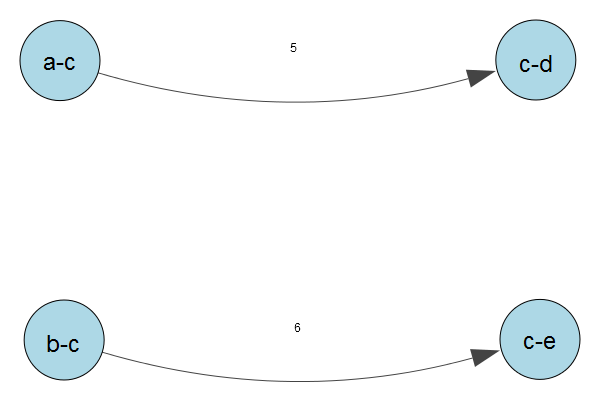

In [21]:
network2 = pp.HigherOrderNetwork(paths, k=2)
g2 = Network2igraph(network2)

visual_style["layout"] = g2.layout_auto()
visual_style["vertex_label"] = g2.vs["name"]
visual_style["edge_label"] = g2.es["weight"]

igraph.plot(g2, 'pathpy_tutorial/g2.png', **visual_style)
display(Image(filename='pathpy_tutorial/g2.png'))

In this representation only two paths of length two actually exist, while - under the assumption that paths in the first-order network are transitive - we would expect four possible paths. If we would have longer paths, we could continue this approach and generate network models with order 3, 4, etc. In a third-order model nodes represent paths of length two, while links capture paths of length three. In general, the link weights of a $k$-th order model capture the statistics of paths of length $k$, thus generalizing the commonly used first-order network view.

As shown [in our previous work](http://dx.doi.org/10.1140/epjb/e2016-60663-0) and [EPJ B](http://link.springer.com/article/10.1140%2Fepjb%2Fe2016-60663-0) such **higher-order network abstractions** are interesting, since they **capture the temporal-topological topology of sequential data on networks**. Moreover, just like the commonly used first-order abstractions, we can interpret them as network topologies which can be analyzed using network-analytic and algebraic methods. [We have further shown](http://dx.doi.org/10.1140/epjb/e2016-60663-0) that these higher-order graphs can be interpreted as Markov models which capture correlations of a given length $k$ that are hidden in the statistics of pathways.

Building on this idea, here we go one step further: We combine several layers of higher-order models up to a maximum order of $k$ to a single **multi-order model**. We can fit such a multi-order model to a given set of pathways using the `MultiOrderModel` class of `pathpy`. We can set the maximum order $maxOrder$ up to which higher-order models should be generated. If we don't specify a maximum order, the model will contain all possible higher-order models up to the maximum path length in the data.

In [22]:
m = pp.MultiOrderModel(paths, maxOrder=2)
print(m)

2017-03-01 17:17:17 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	Generating 2-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	finished.
Multi-order model (max. order = 2, DoF (paths/ngrams) = 7/124)
Layer k = 0	6 nodes, 5 links, 49 paths, DoF (paths/ngrams) = 4/4
Layer k = 1	5 nodes, 4 links, 30 paths, DoF (paths/ngrams) = 1/20
Layer k = 2	4 nodes, 2 links, 11 paths, DoF (paths/ngrams) = 2/100



Again, printing the instance prints a human-readable summary of the underlying model. Here it actually combines three layers from order zero (which simply captures "activation frequencies" of nodes) up to the maximum order of two. Each layer $k$ is simply the $k$-th order model introduced above. We can verify this by plotting the corresponding `HigherOrderNetwork` instances which are stored in the dictionary `layers` of the `MultiOrderNetwork` instance.

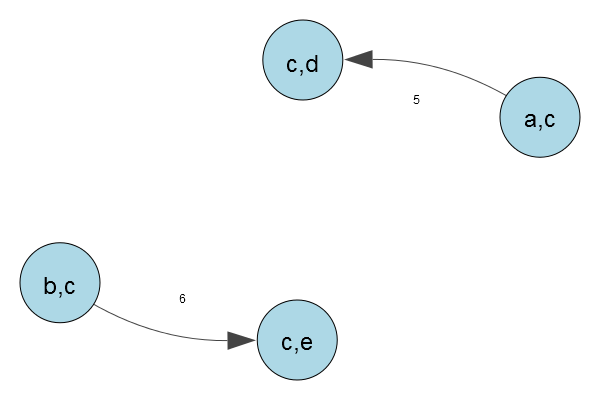

In [23]:
g2 = Network2igraph(m.layers[2])

visual_style["layout"] = g2.layout_auto()
visual_style["vertex_label"] = g2.vs["name"]
visual_style["edge_label"] = g2.es["weight"]

igraph.plot(g2, 'pathpy_tutorial/g2.png', **visual_style)
display(Image(filename='pathpy_tutorial/g2.png'))

<a name="network"></a>
## 6. When is a network a network?
*[Back to outline](#outline)*

What can we do with such a multi-order graphical model of a given set of pathways? We can take a **model selection perspective**, and ask how many layers of higher-order models are needed to model a given set of pathways. In other words, we are interested in the optimal maximum order $K_{opt}$ of a multi-order graphical model needed to model a given data set. By "optimal" we refer to the number of layers minimally needed to best explain the observed pathway statistics, however considering the increase in **model complexity** when adding additional layers.

This optimal maximum order $K_{opt}$ has an interesting interpretation: If for a data set we infer $K_{opt}=1$, this means that there are no significant deviations from the transitivity assumption made by a network representation that would justify the inclusion of higher-order graphical models. In other words: It is - from a model selection perspective - justified to study the underlying system as a network. However, if we find $K_{opt}>1$ this means that the application of a network abstraction (and likewise the use of network-analytic or algebraic methods) is misleading. **Calculating $K_{opt}$ thus allows to answer the crucial question whether a data set should be modeled as a network or not!**

But how can we calculate what is the "optimal" order? And what do we mean when we say that this optimal order balances "model complexity" and "explanatory power". For this, we take a statistical inference view and calculate the likelihoods of multi-order models with different maximum orders under the observed data. Again, if you you are interested in mathematical details please refer to [this recent research paper](https://arxiv.org/abs/1702.05499). 

Here, it is enough to say that we can conveniently calculate the (log-)likelihood of a multi-order model using the likelihood function of the class `MultiOrderModel`. Let us try this with a multi-order model for our toy example that has a maximum order of one.

In [24]:
m1 = pp.MultiOrderModel(paths, maxOrder=1)
print('Likelihood = ', m1.getLikelihood(paths, log=False))

2017-03-01 17:17:17 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	finished.
Likelihood =  1.97212806634e-19


We get a likelihood of the model of $\approx 1.97 \cdot 10^{-19}$. Let us compare this to the likelihood of a multi-order model that adds a layer with a second-order model: 

In [25]:
m2 = pp.MultiOrderModel(paths, maxOrder=2)
print('Likelihood = ', m2.getLikelihood(paths, log=False))

2017-03-01 17:17:17 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	Generating 2-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	finished.
Likelihood =  4.03891827985e-16


Quite naturally, adding a second layer increases the likelihood, i.e. we have increased the explanatory power of the model for our data data. This may trick us into thinking that the second model is the better one. However, we should also take into account that, by adding an additional layer, we make the model more complex. Applying [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor) we should instead search for the **simplest model** which still has reasonable explanatory power, i.e. we should not make the model more complex than neccessary.

The key to a principled decision about the optimal maximum order is to correctly account for the complexity of the model in terms of its **degrees of freedom**, i.e. the number of free parameters that we have fitted to the data. The correct calculation of this number for any graph topology and any order $k$ is one of the main contributions of [this work](https://arxiv.org/abs/1702.05499). 

Luckily, you won't have to deal with this because `pathpy` automatically takes care of it for you. First of all, we can  check the degrees of freedom of our two candidate models simply by printing the model instances.

In [26]:
print(m1)
print(m2)

Multi-order model (max. order = 1, DoF (paths/ngrams) = 5/24)
Layer k = 0	6 nodes, 5 links, 49 paths, DoF (paths/ngrams) = 4/4
Layer k = 1	5 nodes, 4 links, 30 paths, DoF (paths/ngrams) = 1/20

Multi-order model (max. order = 2, DoF (paths/ngrams) = 7/124)
Layer k = 0	6 nodes, 5 links, 49 paths, DoF (paths/ngrams) = 4/4
Layer k = 1	5 nodes, 4 links, 30 paths, DoF (paths/ngrams) = 1/20
Layer k = 2	4 nodes, 2 links, 11 paths, DoF (paths/ngrams) = 2/100



The number that matters here is the first number indicated after Dof (corresponding to paths). The model with maximum order one has five degrees of freedom, while the model of maximum order two has seven degrees of freedom. So the model with maximum order two is more complex than the one with maximum order one because we fit two additional parameters (for the layer of order two).

Again, omitting mathematical details and referring to [this research paper](https://arxiv.org/abs/1702.05499) it turns out that we can apply [Wilk's theorem](https://en.wikipedia.org/wiki/Likelihood-ratio_test#Wilks.27_theorem) to perform a series of [likelihood ratio tests](https://en.wikipedia.org/wiki/Likelihood-ratio_test) in order to determine which maximum order is optimal, while considering the added complexity of higher-order models. And `pathpy` does all of this for you! We can simply call the function `estimateOrder`, which returns the optimal maximum order $K_{opt}$ that we are looking for:

In [27]:
print('Optimal maximum order = ', m2.estimateOrder(paths))

2017-03-01 17:17:17 [Severity.INFO]	Likelihood ratio test for K_opt = 2, x = 22.0
2017-03-01 17:17:17 [Severity.INFO]	Likelihood ratio test, d_1-d_0 = 2
2017-03-01 17:17:17 [Severity.INFO]	Likelihood ratio test, p = 1.67017007903e-05
Optimal maximum order =  2


For our toy example, we see that a (first-order) network abstraction would be misleading. We actually need the second-order graphical model layer, i.e. the added complexity is justified considered the increase in explanatory power for the observed pathways.

Let us consider another toy example, where pathway statistics are actually *exactly* as we expect it to be under the assumption that paths in the first-order network are transitive:

In [28]:
paths = pp.Paths()
paths.addPath('a,c', pathFrequency=2)
paths.addPath('b,c', pathFrequency=2)
paths.addPath('c,d', pathFrequency=2)
paths.addPath('c,e', pathFrequency=2)
paths.addPath('a,c,d', pathFrequency=3)
paths.addPath('b,c,d', pathFrequency=3)
paths.addPath('b,c,e', pathFrequency=3)
paths.addPath('a,c,e', pathFrequency=3)
print(paths)

Number of paths (unique/sub paths/total):	20 (8/76/96)
Nodes:				5
Edges:				4
Max. path length:		2
Avg path length:		1.6
Paths of length k = 0		0 (0/52/52)
Paths of length k = 1		8 (4/24/32)
Paths of length k = 2		12 (4/0/12)



In this special (and quite artificial case) the model with maximum order one and the model with maximum order two have exactly the same likelihoods. I.e., adding the second-order model layer provides no benefit in terms of explanatory power. The reason for this is that there are no correlations in the data that violate the transitivity assumption. We can confirm this as follows:

In [29]:
m1 = pp.MultiOrderModel(paths, maxOrder=1)
print('Likelihood = ', m1.getLikelihood(paths, log=False))

2017-03-01 17:17:17 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	finished.
Likelihood =  3.28861452936e-20


In [30]:
m2 = pp.MultiOrderModel(paths, maxOrder=2)
print('Likelihood = ', m2.getLikelihood(paths, log=False))

2017-03-01 17:17:17 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	Generating 2-th order network layer ...
2017-03-01 17:17:17 [Severity.INFO]	finished.
Likelihood =  3.28861452936e-20


Since the model `m2` is more complex, the `estimateOrder` function will actually reject the more complex model, correctly determining that **a network abstraction of this set of pathways is actually justified**.

In [31]:
print('Optimal maximum order = ', m2.estimateOrder(paths))

2017-03-01 17:17:17 [Severity.INFO]	Likelihood ratio test for K_opt = 2, x = -0.0
2017-03-01 17:17:17 [Severity.INFO]	Likelihood ratio test, d_1-d_0 = 2
2017-03-01 17:17:17 [Severity.INFO]	Likelihood ratio test, p = 1.0
Optimal maximum order =  1


We can vary this example in a way that we slightly distort the statistics of paths, violating the transitivity assumption, but just by a little bit. Precisely, we overrepresent one of the four paths of length two by one occurrence, compared to what we would expect based on the relative frequencies of links:

In [32]:
paths = pp.Paths()
paths.addPath('a,c', pathFrequency=2)
paths.addPath('b,c', pathFrequency=2)
paths.addPath('c,d', pathFrequency=2)
paths.addPath('c,e', pathFrequency=2)
paths.addPath('a,c,d', pathFrequency=3)
paths.addPath('b,c,d', pathFrequency=3)
paths.addPath('b,c,e', pathFrequency=3)
paths.addPath('a,c,e', pathFrequency=4)
print(paths)

Number of paths (unique/sub paths/total):	21 (8/81/102)
Nodes:				5
Edges:				4
Max. path length:		2
Avg path length:		1.61904761905
Paths of length k = 0		0 (0/55/55)
Paths of length k = 1		8 (4/26/34)
Paths of length k = 2		13 (4/0/13)



Let us again calculate the likelihoods for the models with maximum order one and two respectively:

In [33]:
m1 = pp.MultiOrderModel(paths, maxOrder=1)
print('Likelihood = ', m1.getLikelihood(paths, log=False))

2017-03-01 17:17:17 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:17:18 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:17:18 [Severity.INFO]	finished.
Likelihood =  2.8147122155e-21


In [34]:
m2 = pp.MultiOrderModel(paths, maxOrder=2)
print('Likelihood = ', m2.getLikelihood(paths, log=False))

2017-03-01 17:17:18 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:17:18 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:17:18 [Severity.INFO]	Generating 2-th order network layer ...
2017-03-01 17:17:18 [Severity.INFO]	finished.
Likelihood =  2.91588212235e-21


Here, the likelihood of the more complex model is slightly larger, because the additional second-order layer captures the overrepresentation of the path $(a\rightarrow c \rightarrow e)$ which is not expected based on the first-order layer. However, since the model is also more complex, our method correctly determines that the small gain in likelihood does not justify the associated increase in model complexity, thus determining that a first-order network abstraction of this data set is optimal.

In fact, from the output below you can see that we can calculate a $p$-value, which allows us to reject the (alternative) hypothesis that includes a second-order model layer in favor of the (null) hypothesis of the simpler model. We can actually set the significance threshold for the underlying likelihood ratio test as follows:

In [35]:
print('Optimal maximum order = ', m2.estimateOrder(paths, significanceThreshold=0.001))

2017-03-01 17:17:18 [Severity.INFO]	Likelihood ratio test for K_opt = 2, x = 0.101889947837
2017-03-01 17:17:18 [Severity.INFO]	Likelihood ratio test, d_1-d_0 = 2
2017-03-01 17:17:18 [Severity.INFO]	Likelihood ratio test, p = 0.950330962083
Optimal maximum order =  1


Let us finally go beyond synthetic toy examples and test our method in the data sets which we have imported above. We start with the pathway data capturing travel patterns in the London Tube system. Here our method finds that a **network abstraction of the London Tube is misleading**. It actually finds that we need to consider higher-order model layers up to order six, while the layer of order seven is not significant.

In [36]:
tube_model = pp.MultiOrderModel(tube_paths, maxOrder=7)
print('Optimal maximum order = ', tube_model.estimateOrder(tube_paths))

2017-03-01 17:17:18 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:17:18 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:17:18 [Severity.INFO]	Generating 2-th order network layer ...
2017-03-01 17:17:18 [Severity.INFO]	Generating 3-th order network layer ...
2017-03-01 17:17:19 [Severity.INFO]	Generating 4-th order network layer ...
2017-03-01 17:17:20 [Severity.INFO]	Generating 5-th order network layer ...
2017-03-01 17:17:22 [Severity.INFO]	Generating 6-th order network layer ...
2017-03-01 17:17:25 [Severity.INFO]	Generating 7-th order network layer ...
2017-03-01 17:17:29 [Severity.INFO]	finished.
2017-03-01 17:18:17 [Severity.INFO]	Likelihood ratio test for K_opt = 2, x = 46432008.9276
2017-03-01 17:18:17 [Severity.INFO]	Likelihood ratio test, d_1-d_0 = 1659
2017-03-01 17:18:17 [Severity.INFO]	Likelihood ratio test, p = 0.0
2017-03-01 17:19:19 [Severity.INFO]	Likelihood ratio test for K_opt = 3, x = 1484643.01227
2017-03-01 17:19:19 [Se

Despite using a data set with more than 4 million paths and generating higher-order graphical models up to order seven, the whole testing procedure only takes a few minutes (on a six year old laptop computer).

What is great about the unified approach to pathway and temporal network analysis, is that we can directly apply this method to temporal network data. Here we can test whether the time-respecting path statistics which we extracted from the workplace data set above justifies a network abstraction. This specifically allows us to **test whether there are temporal correlations in the sequence of time-stamped interactions which invalidate a (static, first-order) network abstraction**.

We can do this with two (!) lines of python code, testing for the significance of mode layers up to order three.

In [37]:
work_model = pp.MultiOrderModel(work_paths, maxOrder=3)
print('Optimal maximum order = ', work_model.estimateOrder(work_paths))

2017-03-01 17:24:02 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:24:02 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:24:02 [Severity.INFO]	Generating 2-th order network layer ...
2017-03-01 17:24:02 [Severity.INFO]	Generating 3-th order network layer ...
2017-03-01 17:24:02 [Severity.INFO]	finished.
2017-03-01 17:24:03 [Severity.INFO]	Likelihood ratio test for K_opt = 2, x = 6538.14557914
2017-03-01 17:24:03 [Severity.INFO]	Likelihood ratio test, d_1-d_0 = 4521
2017-03-01 17:24:03 [Severity.INFO]	Likelihood ratio test, p = 0.0
2017-03-01 17:24:03 [Severity.INFO]	Likelihood ratio test for K_opt = 3, x = 123.324081918
2017-03-01 17:24:03 [Severity.INFO]	Likelihood ratio test, d_1-d_0 = 20439
2017-03-01 17:24:03 [Severity.INFO]	Likelihood ratio test, p = 1.0
Optimal maximum order =  2


Again, we find that a **network abstraction of the time-stamped interactions in this data set is misleading**. Here we actually need to add a second-order model to explain the observed time-respecting paths, while including an additional third-order model layer is not justified!

Let us conclude our analysis by studying a third data set, which captures [time-stamped E-Mail exchanges in a Polish manufacturing company](http://link.springer.com/chapter/10.1007/978-3-642-21863-7_17). We again extract time-respecting paths for a given maximum time difference $\delta$, create a multi-order model and detect the optimal maximum order, all in just **four lines of python code which only require six seconds of computation!**

In [38]:
email_t = pp.TemporalNetwork.readFile('pathpy_tutorial/CompanyEmails.tedges', sep='\t')
email_paths = pp.Paths.fromTemporalNetwork(email_t, delta=30)

email_model = pp.MultiOrderModel(email_paths, maxOrder=2)
print('Optimal maximum order = ', email_model.estimateOrder(email_paths))

2017-03-01 17:24:03 [Severity.INFO]	Reading time-stamped links ...
2017-03-01 17:24:03 [Severity.INFO]	Building index data structures ...
2017-03-01 17:24:04 [Severity.INFO]	Sorting time stamps ...
2017-03-01 17:24:04 [Severity.INFO]	finished.
2017-03-01 17:24:04 [Severity.INFO]	Extracting time-respecting paths for delta = 30 ...
2017-03-01 17:24:05 [Severity.INFO]	Calculating sub path statistics ... 
2017-03-01 17:24:05 [Severity.INFO]	finished.
2017-03-01 17:24:05 [Severity.INFO]	Generating 0-th order network layer ...
2017-03-01 17:24:05 [Severity.INFO]	Generating 1-th order network layer ...
2017-03-01 17:24:06 [Severity.INFO]	Generating 2-th order network layer ...
2017-03-01 17:24:07 [Severity.INFO]	finished.
2017-03-01 17:24:09 [Severity.INFO]	Likelihood ratio test for K_opt = 2, x = 21871.1297023
2017-03-01 17:24:09 [Severity.INFO]	Likelihood ratio test, d_1-d_0 = 329140
2017-03-01 17:24:09 [Severity.INFO]	Likelihood ratio test, p = 1.0
Optimal maximum order =  1


For this data set, we find that a **first-order network abstraction is sufficient to explain time-respecting paths**, i.e. here temporal correlations in the data do not justify the added complexity of higher-order graphical models.

<a name="conclusion"></a>
## 7. Conclusion
*[Back to outline](#outline)*

In conclusion, above I have shown how you can **test whether a network abstraction of sequential data on pathways and temporal networks is justified or not**. With `pathpy`, answering this crucial question is as simple as it can get. You won't need more than 3-4 lines of simple python code. Hence, a **multi-order analysis with `pathpy` is an extremely simple but crucial first step that should precede an application of network-based data mining and modeling techniques!**.

Moreover, `pathpy` allows to infer multi-order graphical models whose layers can be interpreted as higher-order networks along the lines presented in the [works above](#references). While the argumentation is too long to be included in this tutorial, [this recent work](https://arxiv.org/abs/1702.05499) proves that the **inferred maximum order is the optimal order of a graphical abstraction of sequential data**, e.g. when it comes to the calculation of `PageRank` centralities or prediction tasks. Moreover, [this tutorial](http://www.ingoscholtes.net/research/insights/Temporal_Networks.html) illustrates and visualizes that such higher-order network topologies are crucial to accurately model and predict dynamical processes such as diffusion or epidemic spreading.

I encourage you to get started with `pathpy` and to apply it to your data! If you have any problems, questions or suggestions, feel free to contact me.

*Ingo Scholtes*  

*Zurich, February 23 2017*